In [9]:
import itertools as it
from random import shuffle, sample
import pickle as pkl

# Upgrade version for K-means!
#!pip install threadpoolctl==3.0
#!pip install dit
import numpy as np
import pandas as pd
from joblib import Memory
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import mnist
from PIL import Image
import itertools
from tqdm import tqdm

import dit
import dit.example_dists
from dit.pid import *

from skimage import io
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind, mannwhitneyu

from torchvision import datasets, transforms
import torch

from cifar100coarse import *
from sparse2coarse import *

# Reproducibility
import random
random.seed(0)
np.random.seed(0)

In [10]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
])

In [11]:
fashion = datasets.FashionMNIST(root="\.", download=True, train=True)
cifar_data = datasets.CIFAR100(root="\.", download=True, train=True, transform=transform)
#imagenet = datasets.CIFAR100(root="\.", download=True, train=True)

Files already downloaded and verified


## CIFAR-100 superclasses mapping

In [12]:
cifar_data.targets = sparse2coarse(cifar_data.targets)  

In [135]:
fashion = np.array(fashion.data)
cifar_targets = np.array(cifar_data.targets)
cifar = np.array(cifar_data.data)

# People Superclass
people_class = 14
people_inds = cifar_data.targets == people_class
cifar_people = cifar_data.data[people_inds]

In [136]:
location = './cachedir'
memory = Memory(location, verbose=0)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load datasets

In [137]:
mnist.init_cached = memory.cache(mnist.init)
mnist.init_cached()

In [138]:
train, _, _, _ = mnist.load()

In [139]:
mns = train.reshape(60000, 28, 28)
fashion = fashion.reshape(60000, 28, 28)

In [140]:
mns.shape, fashion[0].shape, cifar[0].shape

((60000, 28, 28), (28, 28), (32, 32, 3))

In [141]:
cifar_cats.data.shape

(2500, 32, 32, 3)

In [142]:
grey_cifar = np.mean(cifar_cats, axis=3, keepdims=True)
grey_cifar.shape

(2500, 32, 32, 1)

Text(0.5, 1.0, "CIFAR-100 'People'")

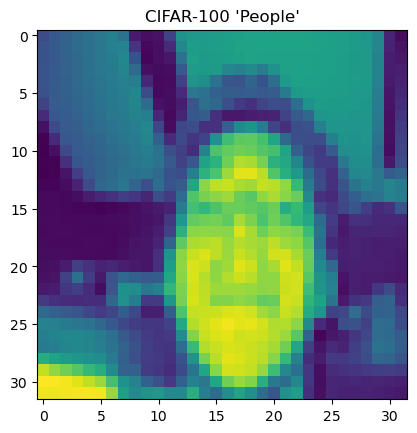

In [145]:
plt.style.use('default')
plt.imshow(grey_cifar[30])
plt.title("CIFAR-100 'People'")

In [146]:
DATASET = "cifar"
rgb = False

if DATASET == "mnist":
    dataset = mns
elif DATASET == "fashion":
    dataset = fashion
elif DATASET == "cifar":
    dataset = grey_cifar
    rgb = True
else:
    print("No valid dataset!!!")
    
print(DATASET)
n = 0

cifar


1


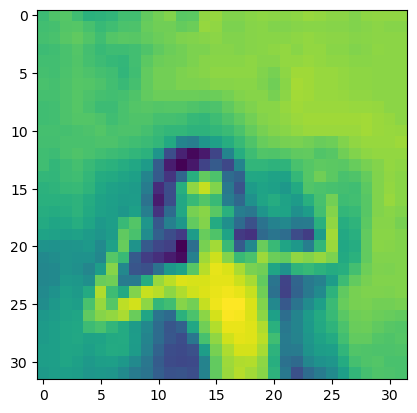

In [147]:
n += 1
print(n)
plt.imshow(dataset[n])

# The Algorithm

It would work like this:

1. Create random ENC1 and ENC2 maps
2. Calculate the decoder with MSE with these maps
3. Find a punctual change in ENC1 or ENC2 that results in a decrease in MSE
4. Repeat 3 until convergence.

In [148]:
class Algorithm:

    def __init__(self, side, signals):
        self.side = side
        self.signals = signals

    def random_enc(self):
        """
        Return a random encoding strategy that assing one of <signals> many signals
        to each of a number <side> of positions
        """
        return np.random.randint(self.signals, size=(self.side))

    def mmse_pairofsignals(self, signal1, signal2):
        """
        Calculate the mmse estimator for a pair of signals, given a fitnessmap and two encoders
        """
        iter1 = np.where(self.enc1 == signal1)[0]
        iter2 = np.where(self.enc2 == signal2)[0]
        samesignal = np.array(list(it.product(iter1, iter2)), dtype=int)
        try:
            return self.fitnessmap[samesignal[:, 0], samesignal[:, 1]]
        except IndexError:
            return np.array([])

    def mmse_decoder(self):
        """
        Calculate the mmse decoder for two encoders,
        given a fitnessmap and a maximum number of signals
        """
        # pairs: combinatorial of all possible pairs (i.e., [(0.0), (0,1), ..., (5, 5)])
        pairs = list(it.product(range(self.signals), repeat=2))
        
        # decoder: uninitialized matrix array of 28x28 (affordance reconstruction)
        decoder = np.empty((self.signals, self.signals))

        samples = []
        mse = []
        for pair in pairs:
            # *pair: unzip tuple: (0, 0) -> 0, 0
            # values: get fitness values given the signals
            values = self.mmse_pairofsignals(*pair)
            if len(values) == 0:
                continue
            # assign the mean fitness value to the decoder's position
            decoder[pair] = values.mean()
            samples.append(values.shape[0])
            # compute mean squared error
            new_mse = ((values - values.mean()) ** 2).mean()
            mse.append(new_mse)
        
        # since each "batch" might not have same size, we have to weight the contribution of each batch
        # to the global mse
        norm_samples = np.array(samples) / np.array(samples).sum()
        return decoder, np.array(mse) @ norm_samples

    def modify_enc(self, pair):
        encoders = {0:self.enc1, 1:self.enc2}
        index, enc = pair
        enc1_backup = self.enc1.copy()
        enc2_backup = self.enc2.copy()
        actual_signal = encoders[enc][index]
        loop = [signal for signal in range(self.signals) if signal != actual_signal]
        for signal in loop:
            encoders[enc][index] = signal
            decoder, mse = self.mmse_decoder()
            if mse < self.mse:
                self.mse = mse
                self.decoder = decoder
                return True
        self.enc1 = enc1_backup
        self.enc2 = enc2_backup
        return False

    def modify_full(self):
        shuffle_encoders = list(it.product(range(self.side), range(2)))
        shuffle(shuffle_encoders)
        for action in shuffle_encoders:
            result = self.modify_enc(action)
            if result:
                return action
        return False

    def main_loop(self):
        self.decoder, self.mse = self.mmse_decoder()
        action = True
        while action:
            action = self.modify_full()
        return self.mse

    def represent(self, showimage=True, title=""):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[i, j] = self.decoder[self.enc1[i], self.enc2[j]]
        if showimage:
            plt.imshow(canvass)
            plt.title(title)
            plt.show()
        return canvass

In [149]:
# This means, create an algorithm for a 28x28 square image, and 6 signals
algo = Algorithm(dataset[n].shape[0], 6)

In [150]:
# Start with random encoders
algo.enc1 = algo.random_enc()
algo.enc2 = algo.random_enc()

In [151]:
print("Initial random encoding 1:", algo.enc1)
print("Initial random encoding 2:", algo.enc2)

Initial random encoding 1: [3 0 3 0 4 2 3 5 5 4 0 2 3 3 1 5 3 4 5 5 3 3 1 1 1 3 2 2 4 3 1 2]
Initial random encoding 2: [3 5 5 5 1 4 2 2 0 1 5 0 4 0 3 2 5 5 0 0 5 1 1 0 3 0 3 0 4 4 0 1]


In [152]:
# Use the MNIST zero above as fitness map
algo.fitnessmap = dataset[n]

In [153]:
# algo.main_loop() is the main function, the cacheing etc is not strictly necessary
# The result is the resulting mean squared error
algo.main_loop()

173.4457181359475

Optimized encoding: [0 0 0 0 0 0 0 0 0 0 0 0 5 5 3 3 3 3 3 3 3 4 1 2 2 2 1 1 1 1 1 1]


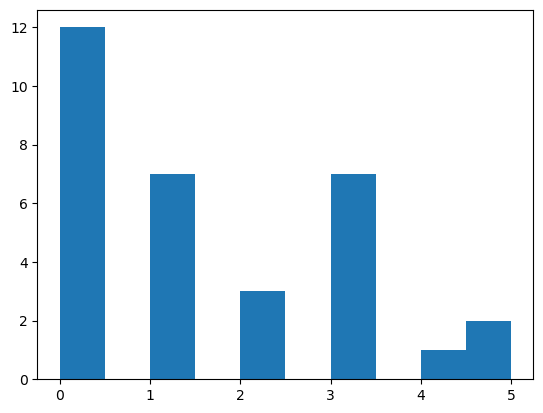

In [154]:
print("Optimized encoding:", algo.enc1)
plt.hist(algo.enc1)
plt.show()

In [155]:
algo.enc2

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 4, 4, 4, 5, 5, 5, 5, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

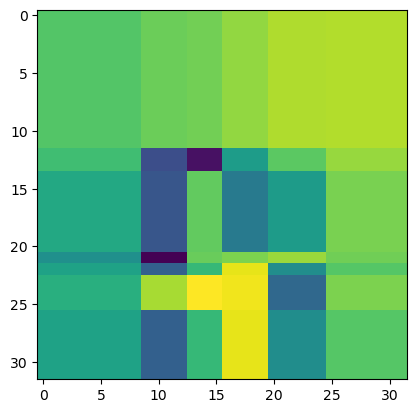

In [156]:
# The reconstructed fitness map
array = algo.represent()

# Fitness optimization in one go

One other simple thing before I take up the question of synergic content: directly optimizing for fitness.

That is to say, now there's one encoder that sees the whole "global array"

In [157]:
class Single_Enc(Algorithm):

    def random_single_enc(self):
        """
        Return a random encoding strategy that assing one of <signals> many signals
        to each of a number <side * side> of positions
        """
        return np.random.randint(self.signals, size=(self.side, self.side))

    def mmse_onesignal(self, signal):
        """
        Calculate the mmse estimator for a signal, given a fitnessmap and an encoders
        """
        axis1, axis2 = np.where(self.enc == signal)
        try:
            return self.fitnessmap[axis1, axis2]
        except IndexError:
            return np.array([])

    def mmse_decoder(self):
        """
        Calculate the mmse decoder for one encoders,
        given a fitnessmap and a maximum number of signals
        """
        decoder = np.empty((self.signals))
        samples = []
        mse = []
        for signal in range(self.signals):
            values = self.mmse_onesignal(signal)
            decoder[signal] = values.mean()
            samples.append(values.shape[0])
            new_mse = ((values - values.mean()) ** 2).mean()
            mse.append(new_mse)
        norm_samples = np.array(samples) / np.array(samples).sum()
        return decoder, np.array(mse) @ norm_samples

    def modify_enc(self, index):
        enc_backup = self.enc.copy()
        actual_signal = self.enc[index]
        loop = [signal for signal in range(self.signals) if signal != actual_signal]
        for signal in loop:
            self.enc[index] = signal
            decoder, mse = self.mmse_decoder()
            if mse < self.mse:
                self.mse = mse
                self.decoder = decoder
                return True
        self.enc = enc_backup
        return False

    def modify_full(self):
        shuffle_encoder = list(it.product(range(self.side), repeat=2))
        shuffle(shuffle_encoder)
        for action in shuffle_encoder:
            result = self.modify_enc(action)
            if result:
                return action
        return False

    def represent(self, title=""):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[i, j] = self.decoder[self.enc[i,j]]
        plt.imshow(canvass)
        plt.title(title)
        return canvass

In [158]:
# Just two signals, so we'll get a "black and white" reconstructed fitness map
single = Single_Enc(dataset[n].shape[0], 2)

In [159]:
single.enc = single.random_single_enc()

In [160]:
single.fitnessmap = dataset[n]

In [161]:
# With just two signals we get much better error than with 6 signals above
# (because we can observe everything at the same time)

single.main_loop()

218.74368789371232

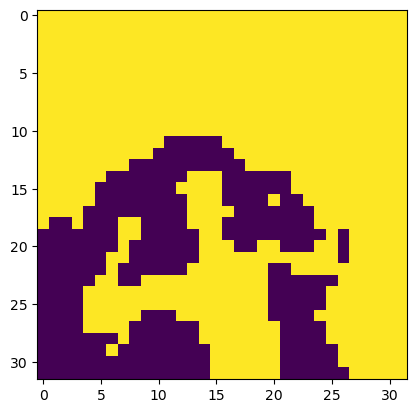

In [162]:
array = single.represent()

In [163]:
#cat_single.main_loop()

In [91]:
#cat_single_arr = cat_single.represent()

In [164]:
"""plt.subplot(1, 2, 1)
plt.imshow(groundtruth)
plt.subplot(1, 2, 2)
plt.imshow(cat_single_arr)
plt.savefig("cat_onestream.pdf")"""

'plt.subplot(1, 2, 1)\nplt.imshow(groundtruth)\nplt.subplot(1, 2, 2)\nplt.imshow(cat_single_arr)\nplt.savefig("cat_onestream.pdf")'

# Correlation (or lack thereof) between synergy and information of the signals

Now, it is to be expected that, if the signals of enc1 and enc2 are to maximize information about a fitness value, they will carry more information about the values of the x and y axes than about fitness. I'll test this now.

The first, easy thing is to calculate the maximum information that one signal alone can carry about fitness, and how much info that signal carries about the axis.

In [165]:
class Single_Enc_One_Side(Algorithm):

    def random_single_enc(self):
        """
        Return a random encoding strategy that assing one of <signals> many signals
        to each of a number <side * side> of positions
        """
        return np.random.randint(self.signals, size=(self.side))

    def mmse_onesignal(self, signal):
        """
        Calculate the mmse estimator for a signal, given a fitnessmap and an encoders
        """
        axis = np.where(self.enc == signal)
        try:
            return self.fitnessmap[axis]
        except IndexError:
            return np.array([])

    def mmse_decoder(self):
        """
        Calculate the mmse decoder for one encoders,
        given a fitnessmap and a maximum number of signals
        """
        decoder = np.empty((self.signals))
        samples = []
        mse = []
        for signal in range(self.signals):
            values = self.mmse_onesignal(signal)
            if len(values) == 0:
                continue
            decoder[signal] = values.mean()
            samples.append(values.shape[0])
            new_mse = ((values - values.mean()) ** 2).mean()
            mse.append(new_mse)
        norm_samples = np.array(samples) / np.array(samples).sum()
        return decoder, np.array(mse) @ norm_samples

    def modify_enc(self, index):
        enc_backup = self.enc.copy()
        actual_signal = self.enc[index]
        loop = [signal for signal in range(self.signals) if signal != actual_signal]
        for signal in loop:
            self.enc[index] = signal
            decoder, mse = self.mmse_decoder()
            if mse < self.mse:
                self.mse = mse
                self.decoder = decoder
                return True
        self.enc = enc_backup
        return False

    def modify_full(self):
        shuffle_encoder = list(range(self.side))
        shuffle(shuffle_encoder)
        for action in shuffle_encoder:
            result = self.modify_enc(action)
            if result:
                return result
        return False

    def main_loop(self):
        self.decoder, self.mse = self.mmse_decoder()
        action = True
        while action:
            action = self.modify_full()
        return self.mse

    def main(self, enc2, enc1):
        self.enc = enc1
        self.main_loop()
        self.mse1 = self.mse
        self.enc1 = self.enc
        self.decoder1 = self.decoder
        self.mse = 1e6
        self.fitnessmap = self.fitnessmap.T
        self.enc = enc2
        self.main_loop()
        self.mse2 = self.mse
        self.enc2 = self.enc
        self.decoder2 = self.decoder
        self.fitnessmap = self.fitnessmap.T
        return True

    def represent_2(self, showimage=True):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[j, i] = self.decoder2[self.enc2[i]]
        if showimage:
            plt.imshow(canvass)
        return canvass

    def represent_1(self, showimage=True):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[i, j] = self.decoder1[self.enc1[i]]
        if showimage:
            plt.imshow(canvass)
        return canvass
    
    def get_decoders(self):
        new_enc1 = np.empty(shape=self.enc1.shape)
        new_enc2 = np.empty(shape=self.enc2.shape)
        for i in range(len(self.decoder1)):
            inds1 = self.enc1 == i
            inds2 = self.enc2 == i
            
            new_enc1[inds1] = self.decoder1[i]
            new_enc2[inds2] = self.decoder2[i]
            
        return new_enc1, new_enc2

    def get_affordance_encodings(self):
        encoding = []
        for i,tup1 in enumerate(self.decoder1):
            inds = list(it.product([tup1],self.decoder2))
            for j,ind in enumerate(inds):
                encod = self.fitnessmap[i][j]
                encoding.append((str(ind[0]), str(ind[1]), str(encod)))
       
        return encoding
    
    def get_sensory_encodings(self):  
        encoding = [(str(x), str(self.decoder2[i]), str(y))
                    for i,(x,y) in enumerate(list(zip(self.decoder1, self.fitnessmap)))]
        return encoding
    
    def get_pid_measures(self, n, encoding, show=True):
        pid_myopic = dit.Distribution(encoding, [1/len(encoding)]*len(encoding))
        pid_myopic.set_rv_names(list(range(n)))
        
        pid_measure = PID_BROJA(pid_myopic)
        
        pid_names = ["{0}", "{1}", "{0}{1}", "{0:1}"]
        pid_dict = {}
        for i,k in enumerate(pid_measure._pis.keys()):
            value = pid_measure.get_pi(k)
            pid_dict[pid_names[i]] = value
        
        if show:
            print("PID BROJA:\n", pid_measure)
        
        return pid_dict
    
        
    def get_mutual_info(self):
        encoding_1 = [(str(x), str(y)) for (x,y) in list(zip(self.decoder1, self.fitnessmap))]
        encoding_2 = [(str(x), str(y)) for (x,y) in list(zip(self.decoder2, self.fitnessmap))]
        
        dist_enc_1 = dit.Distribution(encoding_1, [1/len(encoding_1)]*len(encoding_1))
        dist_enc_2 = dit.Distribution(encoding_2, [1/len(encoding_2)]*len(encoding_2))
        
        mutual_1 = dit.shannon.mutual_information(dist_enc_1, [0], [1])
        mutual_2 = dit.shannon.mutual_information(dist_enc_2, [0], [1])
        
        return mutual_1, mutual_2, dist_enc_1, encoding_1
    
    def get_entropy(self, distribution):

        # Calculate the frequency distribution
        unique_values, counts = np.unique(distribution.flatten(), return_counts=True)
        
        #distribution_dict = dict(zip(map(str, unique_values), counts/len(self.fitnessmap.flatten())))
        distribution_dict = dict(zip(map(lambda x: (str(x),), unique_values), counts/len(distribution.flatten())))
                
        entropy_fitness = dit.Distribution(distribution_dict)
        
        return dit.shannon.entropy(entropy_fitness)
    
def merge_dicts(dicts):
    merged_dict = {}
    for key in dicts[0].keys():
        merged_dict[key] = [d[key] for d in dicts]

    return merged_dict

In [166]:
def distribution_signals(dist_inp, total_range):
    dist = {n:0. for n in total_range}
    for x in dist_inp:
        dist[x] = dist.get(x,0) + 1
        
    for k,v in dist.items():
        dist[k] = v/dist_inp.shape[0]
    
    return dist

In [167]:
def plot_dist_signals(dists):
    plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    inds = list(itertools.product([0,1], [0,1]))
    
    for i,(n,d) in enumerate(dists.items()):
        axs[inds[i]].bar(x=list(d.keys()), height=list(d.values()))
        axs[inds[i]].set_title(n)
        axs[inds[i]].set_xlabel("Dimension")
        axs[inds[i]].set_ylabel("Probability")
        axs[inds[i]].set_yticks(np.arange(0, 0.71, 0.1))
        
        
    plt.show()

In [168]:
def quantize_fitnessmaps(fm, n_colors):

    arr = fm.reshape((-1, 1))
    kmeans = KMeans(n_clusters=n_colors, random_state=1).fit(arr)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    less_colors = centers[labels].reshape(fm.shape).astype('uint8')

    return less_colors

In [169]:
def plot_results(ax, df, columns, name_value, title):
    plt.style.use('seaborn')
    # Calculate mean and standard deviation for each signal and MSE column
    means = df.groupby('Signal').mean()
    stds = df.groupby('Signal').std()

    # Reshape the DataFrame for Seaborn
    df_seaborn = pd.melt(df[["Signal"] + columns], id_vars='Signal', var_name=name_value, value_name='Value')

    # Plotting using Seaborn
    #plt.figure(figsize=(10, 6))
    sns.lineplot(x='Signal', y='Value', hue=name_value, data=df_seaborn, ci='sd', marker='o', ax=ax)

    # Set labels and title
    ax.set_xlabel('Signal', fontsize=18)
    ax.set_ylabel(name_value, fontsize=18)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title(title, fontsize=20)

    ax.legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize=16)

In [170]:
def get_spatial_entropy(dist, num_signals):
    """
    Spatial entropy measure by: Claramunt, C. (2005). A spatial form of diversity
    The OFF data is not used for the final computation since we are only interested in the distribution of
    ON signals. Adding the OFF terms biases the spatial entropy in an undesired way.
    """
    
    total_categories = len(dist.keys())
    category = []
    prob_ON = []
    prob_OFF = []
    
    for k,v in dist.items():
        if v != 0:
            category.append("ON")
            prob_ON.append(v)
        else:
            prob_OFF.append(1/total_categories)
            category.append("OFF")
    
    prob_ON = np.array(prob_ON)
    prob_OFF = np.array(prob_OFF)
    
    df = pd.DataFrame({
        'x': list(dist.keys()),
        'class': category
    })
    

    # Extract intra and extra distances from a Euclidean distance matrix
    dist_matrix = pd.DataFrame(np.linalg.norm(df[['x', 'x']].values - df[['x', 'x']].values[:, None], axis=-1))

    # Intra-distance for each class
    intra = [dist_matrix.loc[df['class'] == let, df['class'] == let].values for let in ['ON', 'OFF']]
    
    # Extra-distance for each class
    extra = [dist_matrix.loc[df['class'] == let, df['class'] != let].values for let in ['ON', 'OFF']]

    # Average Intra-distance for each class
    intra_green = np.mean(intra[0][intra[0] != 0])
    intra_white = np.mean(intra[1][intra[1] != 0])

    # Average Extra-distance for each class
    extra_green = np.mean(extra[0][extra[0] != 0])
    extra_white = np.mean(extra[1][extra[1] != 0])

    # Average Extra-distance for ON and OFF classes
    extra_ON = np.mean(extra[0][extra[0] != 0])
    extra_OFF = np.mean(extra[1][extra[1] != 0])

    # Average Intra-distance for ON class
    intra_ON = np.mean(intra[0][intra[0] != 0])

    # Average Intra-distance for OFF
    intra_OFF = np.mean(intra[1][intra[1] != 0])

    # Entropy for each class
    entropy_ON = prob_ON * np.log2(1/prob_ON)
    entropy_OFF = prob_OFF * np.log2(1/prob_OFF)

    # Claramunt's entropy ratios (intra/extra)
    ON_CL = intra_ON / extra_ON
    OFF_CL = intra_OFF / extra_OFF
    
    # Claramunt's spatial entropy
    spatial_entropy = np.sum(entropy_ON * ON_CL)
    
    return spatial_entropy

In [171]:
def get_results(raw_fitnessmaps, total_signals, rgb, n=3,
                show_fit=False, showimage=False, show_pid=False,
                verbose=False, plot_dists=False):
    
    ts = len(total_signals)
    repeats = len(raw_fitnessmaps)*len(total_signals)
    
    signals = []
    mse1_avg = []
    mse2_avg = []
    msi1_avg = []
    msi2_avg = []
    ment1_avg = []
    ment2_avg = []
    mre_avg = []
    msyn_avg = []
    
    gse1_avg = []
    gse2_avg = []
    gsi1_avg = []
    gsi2_avg = []
    gent1_avg = []
    gent2_avg = []
    gre_avg = []
    gsyn_avg = []
    
    if rgb:
        fitnessmaps = [quantize_fitnessmaps(fm, n) for fm in raw_fitnessmaps] 
    
    for s,num_signals in enumerate(total_signals):
        
        print("\nSignal", num_signals)
        
        for r, fitnessmap in tqdm(enumerate(fitnessmaps)):

            oneside = Single_Enc_One_Side(fitnessmap.shape[0], num_signals)
            oneside.fitnessmap = fitnessmap
            oneside.main(oneside.random_single_enc(), oneside.random_single_enc())
            
            if verbose and s == 0:
                plt.style.use('default')
                print(f"Entropy of fitnessmap: {oneside.get_entropy(): .2f}")
                pass

            if show_fit and s == 0:
                plt.style.use('default')
                plt.title("Raw Image")
                plt.imshow(raw_fitnessmaps[r])
                plt.show()
                plt.title("Affordance")
                plt.imshow(fitnessmap)
                plt.show()

            ##########
            # MYOPIC #
            ##########
            # Get sensory information and MSE for the MYOPIC encoders                
            oneside.fitnessmap = np.arange(oneside.side)
                        
            oneside.enc = oneside.enc1
            #myopic1 = oneside.enc
            decoder_myopic_1, mse_myopic_sensory_1 = oneside.mmse_decoder()
            
            oneside.enc = oneside.enc2
            #myopic2 = oneside.enc
            decoder_myopic_2, mse_myopic_sensory_2 = oneside.mmse_decoder()
            
            decoder_myopic_1 = np.round(decoder_myopic_1)
            decoder_myopic_2 = np.round(decoder_myopic_2)
            
            oneside.decoder1 = decoder_myopic_1
            oneside.decoder2 = decoder_myopic_2
            dec_myopic_1, dec_myopic_2 = oneside.get_decoders()
            
            oneside.decoder1 = dec_myopic_1
            oneside.decoder2 = dec_myopic_2
            
            # PID encoders
            #myopic_sensory_encoding = oneside.get_sensory_encodings()
            #pid_sensory_myopic = oneside.get_pid_measures(3, myopic_sensory_encoding, show=show_pid)
            #pid_sensory_myopic['{0}'] = oneside.get_mutual_info()[0]
            #pid_sensory_myopic['{1}'] = oneside.get_mutual_info()[1]

            # Get affordance information and MSE for the MYOPIC encoders
            algo = Algorithm(fitnessmap.shape[0], num_signals)
            algo.fitnessmap = fitnessmap
            algo.enc1 = oneside.enc1
            algo.enc2 = oneside.enc2
            algo.decoder, algo.mse = algo.mmse_decoder()
            recons_error_myopic = round(algo.mse, 3)
            repmyopic = algo.represent(showimage=showimage, title="Direct")
            
            # PID affordance matrix
            #oneside.fitnessmap = fitnessmap
            #myopic_affordance_encoding = oneside.get_affordance_encodings()
            #pid_affordance_myopic = oneside.get_pid_measures(3, myopic_affordance_encoding, show=show_pid)

            if verbose:
                print(f"MSE encoder 1 - basic property 1: {mse_myopic_sensory_1: .2f}")
                print(f"MSE encoder 2 - basic property 2: {mse_myopic_sensory_2: .2f}")
                print(f"MI encoder 1 - basic property 1: {pid_sensory_myopic['{0}']: .2f}")
                print(f"MI encoder 2 - basic property 2: {pid_sensory_myopic['{1}']: .2f}")
                print(f"MYOPIC. Affordance reconstruction error: {recons_error_myopic: .2f}")


            ##########
            # 'GOOD' #
            ##########            
            algo.enc1 = oneside.random_enc()
            algo.enc2 = oneside.random_enc()
            recons_error_good = algo.main_loop()

            oneside.fitnessmap = np.arange(oneside.side)
            # get mse for each encoder its basic property
            oneside.enc = algo.enc1
            decoder_synergy_1, mse_synergy_sensory_1 = oneside.mmse_decoder()
            oneside.enc = algo.enc2
            decoder_synergy_2, mse_synergy_sensory_2 = oneside.mmse_decoder()

            oneside.enc1 = algo.enc1
            oneside.enc2 = algo.enc2
            
            repsynergistic = algo.represent(showimage=showimage, title="Indirect")
            
            decoder_synergy_1 = np.round(decoder_synergy_1)
            decoder_synergy_2 = np.round(decoder_synergy_2)
            
            oneside.decoder1 = decoder_synergy_1
            oneside.decoder2 = decoder_synergy_2
            dec_synergy_1, dec_synergy_2 = oneside.get_decoders()

            oneside.decoder1 = dec_synergy_1
            oneside.decoder2 = dec_synergy_2
                        
            synergy_sensory_encoding = oneside.get_sensory_encodings()
            #pid_sensory_synergy = oneside.get_pid_measures(3, synergy_sensory_encoding, show=show_pid)
            #pid_sensory_synergy['{0}'] = oneside.get_mutual_info()[0]
            #pid_sensory_synergy['{1}'] = oneside.get_mutual_info()[1]

            # PID affordance matrix
            #oneside.fitnessmap = fitnessmap
            #syenergy_affordance_encoding = oneside.get_affordance_encodings()
            #pid_affordance_synergy = oneside.get_pid_measures(3, syenergy_affordance_encoding, show=show_pid)
    

            if verbose:
                print(f"\nMSE encoder 1 - basic property 1: {mse_synergy_sensory_1: .2f}")
                print(f"MSE encoder 2 - basic property 2: {mse_synergy_sensory_2: .2f}")
                print(f"MI encoder 1 - basic property 1: {pid_sensory_synergy['{0}']: .2f}")
                print(f"MI encoder 2 - basic property 2: {pid_sensory_synergy['{1}']: .2f}")
                print(f"GOOD. Affordance reconstruction error: {recons_error_good: .2f}")
            
            
            total_range = np.arange(oneside.side)
            dist_myopic_1 = distribution_signals(dec_myopic_1, total_range)
            dist_myopic_2 = distribution_signals(dec_myopic_2, total_range)

            dist_synergy_1 = distribution_signals(dec_synergy_1, total_range)
            dist_synergy_2 = distribution_signals(dec_synergy_2, total_range)

            spatial_entropy_myopic_1 = get_spatial_entropy(dist_myopic_1, num_signals)
            spatial_entropy_myopic_2 = get_spatial_entropy(dist_myopic_2, num_signals)
            spatial_entropy_synergy_1 = get_spatial_entropy(dist_synergy_1, num_signals)
            spatial_entropy_synergy_2 = get_spatial_entropy(dist_synergy_2, num_signals)
                
            if plot_dists:
                print(spatial_entropy_myopic_1)
                print(spatial_entropy_myopic_2)
                print(spatial_entropy_synergy_1)
                print(spatial_entropy_synergy_2)

                plot_dist_signals({"$E_{B}$: Direct": dist_myopic_1,
                                   "$E_{C}$: Direct": dist_myopic_2,
                                   "$E_{B}$: Indirect": dist_synergy_1,
                                   "$E_{C}$: Indirect": dist_synergy_2})
                      
                    
            # NOT PLOTTING PID!!!!
            pid_sensory_myopic = {}
            pid_affordance_myopic = {}
            pid_sensory_myopic['{0}'] = 0
            pid_sensory_myopic['{1}'] = 0
            pid_affordance_myopic['{0:1}'] = 0
            
            pid_sensory_synergy = {}
            pid_affordance_synergy = {}
            pid_sensory_synergy['{0}'] = 0
            pid_sensory_synergy['{1}'] = 0
            pid_affordance_synergy['{0:1}'] = 0
            
            
            signals.append(num_signals)
            mse1_avg.append(mse_myopic_sensory_1)
            mse2_avg.append(mse_myopic_sensory_2)
            msi1_avg.append(pid_sensory_myopic['{0}'])
            msi2_avg.append(pid_sensory_myopic['{1}'])
            ment1_avg.append(spatial_entropy_myopic_1)
            ment2_avg.append(spatial_entropy_myopic_2)
            mre_avg.append(recons_error_myopic)
            msyn_avg.append(pid_affordance_myopic['{0:1}'])

            gse1_avg.append(mse_synergy_sensory_1)
            gse2_avg.append(mse_synergy_sensory_2)
            gsi1_avg.append(pid_sensory_synergy['{0}'])
            gsi2_avg.append(pid_sensory_synergy['{1}'])
            gent1_avg.append(spatial_entropy_synergy_1)
            gent2_avg.append(spatial_entropy_synergy_2)
            gre_avg.append(recons_error_good)
            gsyn_avg.append(pid_affordance_synergy['{0:1}'])
            
    df = pd.DataFrame({
                        "Signal": signals,
                        # MSE sensory signals
                        "MSE_sensory_myopic_1": mse1_avg,
                        "MSE_sensory_myopic_2": mse2_avg,
                        "MSE_sensory_synergy_1": gse1_avg,
                        "MSE_sensory_synergy_2": gse2_avg,
                        # MI sensory signals
                        "MI_sensory_myopic_1": msi1_avg,
                        "MI_sensory_myopic_2": msi2_avg,
                        "MI_sensory_synergy_1": gsi1_avg,
                        "MI_sensory_synergy_2": gsi2_avg,
                        # Spatial Entropy sensory signals
                        "SENT_sensory_myopic_1": ment1_avg,
                        "SENT_sensory_myopic_2": ment2_avg,
                        "SENT_sensory_synergy_1": gent1_avg,
                        "SENT_sensory_synergy_2": gent2_avg,
                        # MSE affordance
                        "MSE_affordance_myopic": mre_avg,
                        "MSE_affordance_synergy": gre_avg,
                        # Synergy affordance
                        "SynInfo_affordance_myopic": msyn_avg,
                        "SynInfo_affordance_synergy": gsyn_avg,
        
                    })
        
    return df

## Experiment using a set of random fitnessmaps to evaluate the myopic and synergistic encoder using different signals
### The PID computation for signals > 6 will take quite a bit of time for CIFAR images

I'm taking the distribution of signals after the decoder's mapping. Why? To account for the information shared between encoder and decoder. For instance, if signal 0 -> 1.5 and signal 1 -> 1.5, then the decoder's entropy will be zero, while the encoder's entropy will be 1 bit.

In [133]:
n_seed = 0

Seed 0
[1701]

Signal 8


0it [00:00, ?it/s]

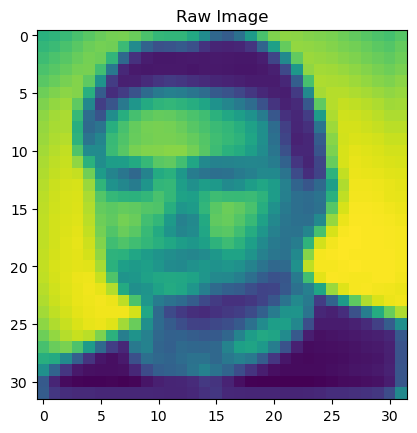

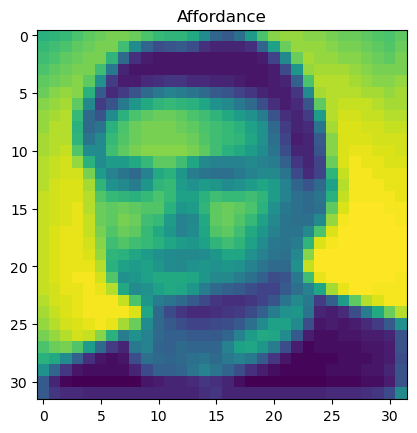

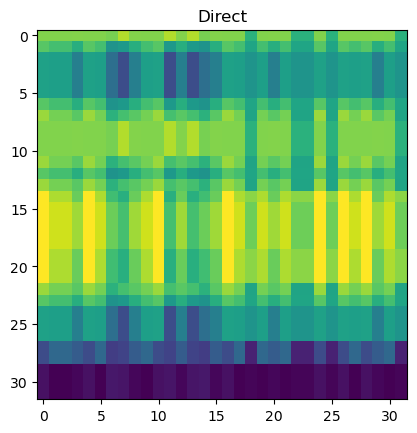

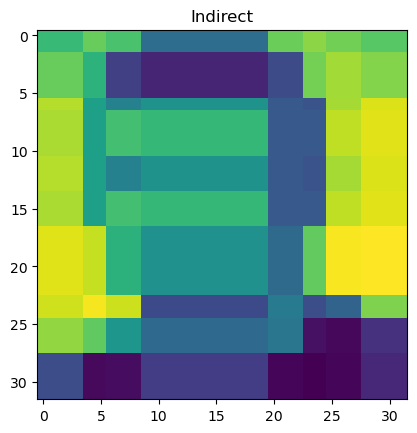

2.601622235549402
1.378643166833544
3.4208721105649333
3.210875115353497


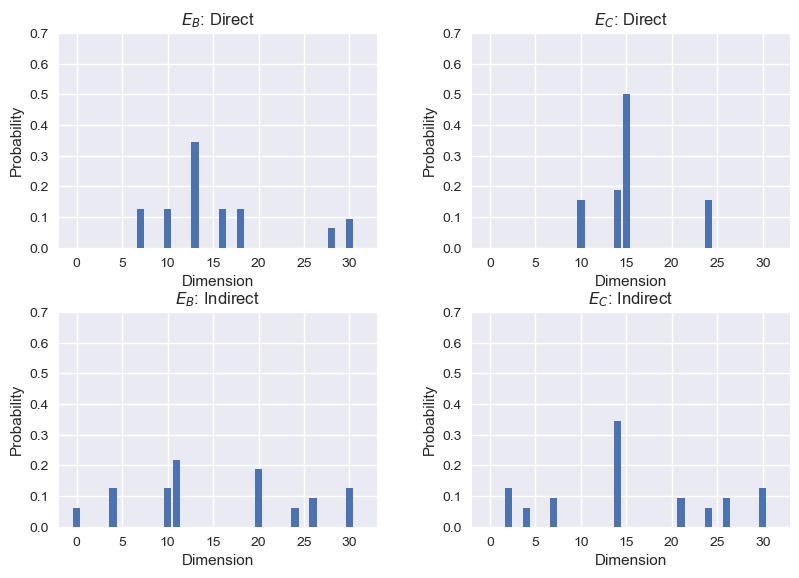

1it [00:04,  4.49s/it]


In [134]:
signals = [2, 4, 6, 8]
signals = [8]
print("Seed", n_seed)
np.random.seed(n_seed)
ind_images = np.random.choice(list(range(len(dataset))), size=(100))
ind_images = [1701]
print(ind_images)
fitness_maps = dataset[ind_images][:]
plt.style.use('default')

n_seed += 1

"""rgb: if the image is rgb, we quantize it to reduce the number of possible pixel values
        to make the PID computaion tractable. Method: K-means
   n: number of different clusters (i.e., pixel values) of K-means
   show_fit: plot fitnessmap
   verbose: show data
   show_pid: plot PID
   plot_dists: plot distribution of signals per encoder
"""

df = get_results(fitness_maps, signals, rgb=rgb, n=50, showimage=True,
                               show_fit=True, verbose=False,
                               show_pid=False, plot_dists=True)

## Legend
**MSE_sensor**: MSE between each encoder (myopic and synergsitic) and its sensory modality\
**MI_sensory**: Mutual Information between each encoder (myopic and synergsitic) and its sensory modality\
**SENT_senso**: Spatial Entropy between each encoder (myopic and synergsitic) and its sensory modality\
**MSE_afford**: MSE of affordance for pairs of myopic and synergsitic encoders-decoders\
**Synergy_af**: Syenrgsitic information between the encoders and the affordance vlaue

[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]


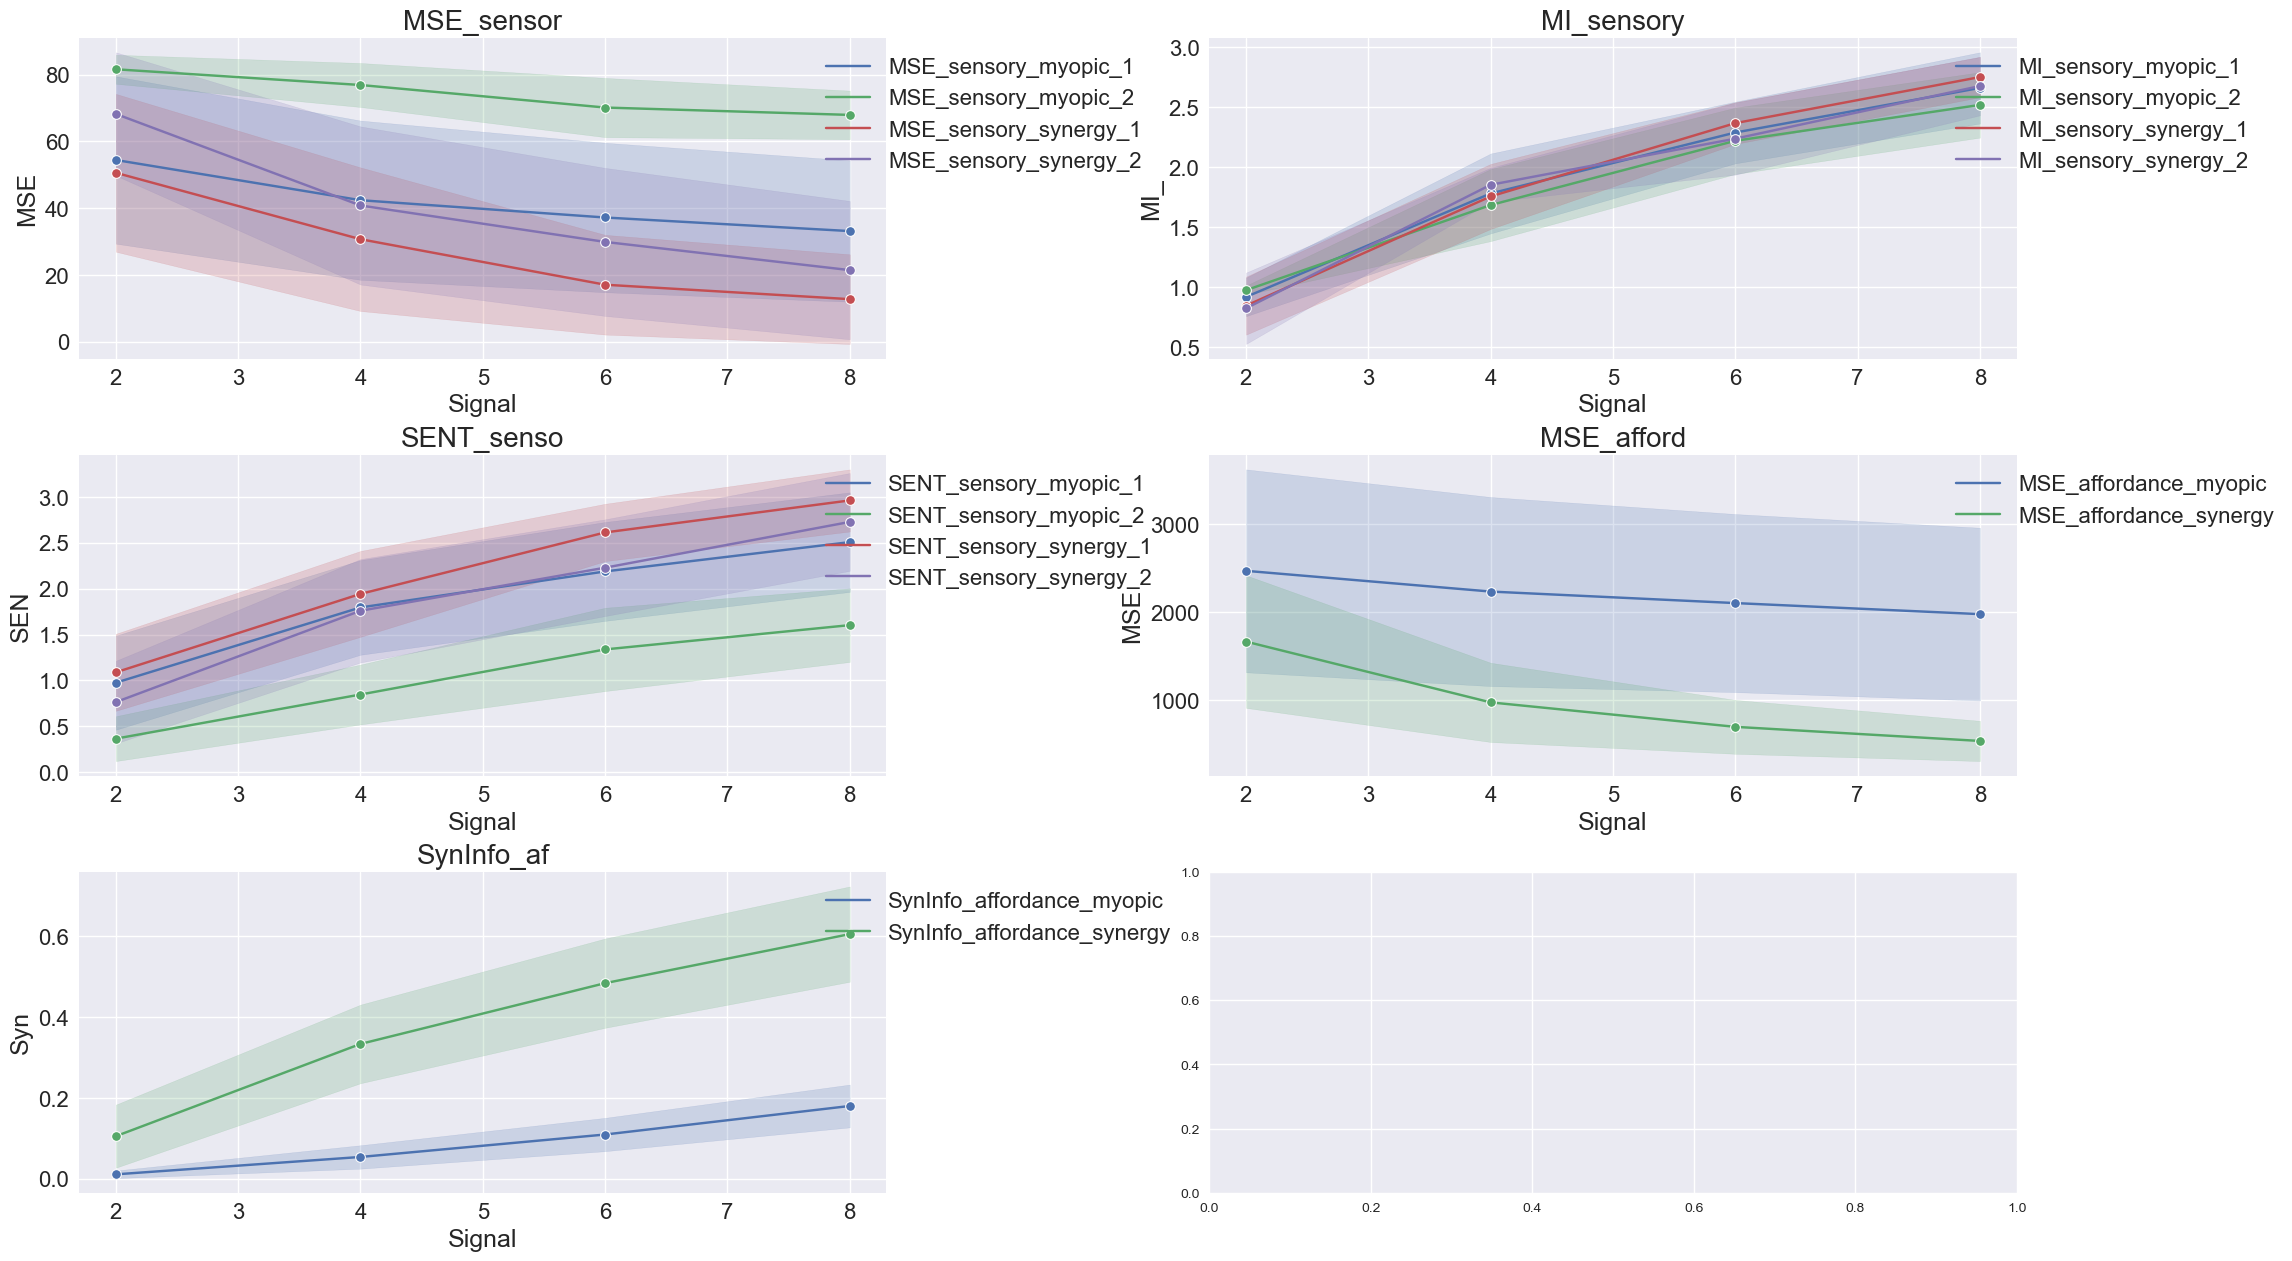

In [102]:
df = pd.read_csv("synergistic_encoders_cifar100_People")

columns = df.columns[1:]

fig, ax = plt.subplots(3, 2, figsize=(25, 15))
inds = list(itertools.product([0,1,2], [0,1]))
#fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.4)
print(inds)
inds_data = [1, 5, 9, 13, 15, len(columns)]

for i in range(5):
    
    cols = list(columns[inds_data[i]:inds_data[i+1]])
    plot_results(ax[inds[i]], df, cols,
                 cols[0][:3], title=cols[0][:10])


plt.show()

In [392]:
new_df = pd.read_csv("synergistic_encoders_mnist10")
new_df = new_df.dropna()
new_df = new_df[new_df["Signal"] == 8]

In [172]:
def remove_outliers(df, threshold=3):
    """
    Remove outliers from DataFrame based on z-score.
    
    Parameters:
        df (DataFrame): Input DataFrame
        columns (list): List of columns to check for outliers
        threshold (int or float): Threshold for z-score
        
    Returns:
        DataFrame: DataFrame with outliers removed
    """
    columns = df.columns[2:]
    z_scores = df[columns].apply(lambda x: np.abs((x - x.mean()) / x.std()))
    df_filtered = df[(z_scores < threshold).all(axis=1)]
    return df_filtered

# Remove outliers from columns 'A' and 'B' based on z-score
df_cleaned = remove_outliers(new_df, 2)

In [363]:
df_cleaned.head()

,Unnamed: 0,Signal,MSE_sensory_myopic_1,MSE_sensory_myopic_2,MSE_sensory_synergy_1,MSE_sensory_synergy_2,MI_sensory_myopic_1,MI_sensory_myopic_2,MI_sensory_synergy_1,MI_sensory_synergy_2,SENT_sensory_myopic_1,SENT_sensory_myopic_2,SENT_sensory_synergy_1,SENT_sensory_synergy_2,MSE_affordance_myopic,MSE_affordance_synergy,Synergy_affordance_myopic,Synergy_affordance_synergy
132,150,8,53.761012,39.763889,34.954082,50.979396,2.593992,2.179362,2.793764,2.419476,1.256210,1.509569,2.407849,1.679378,1742.400,625.796875,0.091067,0.199843
134,152,8,27.520833,55.791667,39.154762,58.702381,2.522563,1.931923,2.856312,2.017600,2.537208,1.577547,1.835335,1.097748,2139.993,976.662149,0.171433,0.235190
136,154,8,57.595238,44.992772,44.847222,57.330782,2.624519,2.211961,2.404347,2.216450,1.303980,2.400410,1.855323,1.234213,2956.630,1314.382201,0.123157,0.172776
143,161,8,39.279762,51.642857,32.901786,51.275510,2.651479,2.343294,2.663926,2.435127,2.136028,2.160881,2.204057,1.129223,2128.657,1279.257015,0.219722,0.220433
144,162,8,54.007653,58.306548,34.040476,36.583333,2.335390,2.472209,2.870254,2.448816,1.547104,1.378722,2.492377,2.257561,1093.987,784.723469,0.129351,0.195719


In [358]:
df_cleaned.corr()

,Unnamed: 0,Signal,MSE_sensory_myopic_1,MSE_sensory_myopic_2,MSE_sensory_synergy_1,MSE_sensory_synergy_2,MI_sensory_myopic_1,MI_sensory_myopic_2,MI_sensory_synergy_1,MI_sensory_synergy_2,SENT_sensory_myopic_1,SENT_sensory_myopic_2,SENT_sensory_synergy_1,SENT_sensory_synergy_2,MSE_affordance_myopic,MSE_affordance_synergy,Synergy_affordance_myopic,Synergy_affordance_synergy
Unnamed: 0,1.000000,NaN,0.044414,0.109914,0.174976,0.159723,-0.211131,0.051444,-0.262614,0.099371,0.088298,0.014351,-0.180425,-0.069369,0.226511,0.145432,-0.193552,0.102471
Signal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSE_sensory_myopic_1,0.044414,NaN,1.000000,0.157904,0.542709,-0.098848,-0.417698,-0.084415,-0.134913,0.100727,-0.777641,-0.055550,-0.200121,0.159563,0.173278,0.124460,-0.373871,-0.003037
MSE_sensory_myopic_2,0.109914,NaN,0.157904,1.000000,0.051694,0.340541,-0.069279,-0.480206,0.184720,-0.143313,-0.088367,-0.745685,0.115209,-0.183881,-0.005068,-0.013137,-0.329438,-0.185814
MSE_sensory_synergy_1,0.174976,NaN,0.542709,0.051694,1.000000,-0.101255,-0.303957,-0.146570,-0.380555,-0.034416,-0.276616,-0.040923,-0.708656,0.123239,0.015942,-0.060256,-0.239290,0.014493


In [210]:
def plot_comparisons(new_df, signal=8, n=2):
    
    new_df = new_df[new_df["Signal"] == signal]

    my_dict = {(0, 0): ["SynInfo_affordance_myopic", f"MSE_sensory_myopic_1",
                        "SynInfo_affordance_synergy", f"MSE_sensory_synergy_1",
                        "SynInfo_affordance_myopic", f"MSE_sensory_myopic_2",
                        "SynInfo_affordance_synergy", f"MSE_sensory_synergy_2",
                        "Synergistic Information", "MSE Sensory Estimate"],

               (0, 1): [f"SENT_sensory_myopic_1", f"MSE_sensory_myopic_1",
                        f"SENT_sensory_synergy_1", f"MSE_sensory_synergy_1",
                        f"SENT_sensory_myopic_2", f"MSE_sensory_myopic_2",
                        f"SENT_sensory_synergy_2", f"MSE_sensory_synergy_2",
                        "Sensory Spatial Entropy", "MSE Sensory Estimate"],

               (1, 0): [f"MSE_sensory_myopic_1", "MSE_affordance_myopic",
                        f"MSE_sensory_synergy_1", "MSE_affordance_synergy",
                        f"MSE_sensory_myopic_2", "MSE_affordance_myopic",
                        f"MSE_sensory_synergy_2", "MSE_affordance_synergy",
                        "MSE Sensory Estimate", "MSE Affordance Estimate"],
               
               (1, 1): ["SynInfo_affordance_myopic", "MSE_affordance_myopic",
                        "SynInfo_affordance_synergy", "MSE_affordance_synergy",
                        "Synergistic Information", "MSE Affordance Estimate"],
        }

    for k,v in my_dict.items():
        if len(v) == 10:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
            axs = [ax1, ax2]
            inds = [0, 4]
            
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(20, 7), sharey=True)
            axs = [ax1]
            inds = [0]
            
        fig.subplots_adjust(hspace=0.3, wspace=0.1)
        # axis: ax=ax[k[0]][k[1]]
        
        for i in inds:
            sns.scatterplot(data=new_df, x=v[i], y=v[i+1],
                            color='blue', label='Direct', ax=axs[max(0, i-3)])
            sns.scatterplot(data=new_df, x=v[i+2], y=v[i+3],
                            color='red', label='Indirect', ax=axs[max(0, i-3)])

            sns.scatterplot(x=[new_df[v[i]].mean()], y=[new_df[v[i+1]].mean()], marker="X", s=500,
                            color='blue', label='Mean Direct', ax=axs[max(0, i-3)])

            sns.scatterplot(x=[new_df[v[i+2]].mean()], y=[new_df[v[i+3]].mean()], marker="X", s=500,
                            color='red', label='Mean Indirect', ax=axs[max(0, i-3)])
            

            """plt.xlabel(v[4], fontsize=24)
            plt.ylabel(v[5], fontsize=24)

            plt.tick_params(axis='x', labelsize=22)
            plt.tick_params(axis='y', labelsize=22)
            plt.legend(fontsize=15)"""

            axs[max(0, i-3)].set_xlabel('')
            axs[max(0, i-3)].set_ylabel(v[-1], fontsize=24)

            axs[max(0, i-3)].tick_params(axis='x', labelsize=22)
            axs[max(0, i-3)].tick_params(axis='y', labelsize=22)
            
            axs[max(0, i-3)].legend("")
            #ax[k[0]][k[1]].set_title(f"Encoders: {n} | {v[0][:5]}", fontsize=20)

        # P-Value
        t_statistic_a, p_value_a = ttest_ind(new_df[v[0]], new_df[v[2]])
        t_statistic_b, p_value_b = ttest_ind(new_df[v[1]], new_df[v[3]])

        print(f"\n {v[4]} | {v[5]}")
        print(f"P-value {v[4]}: {p_value_a:.2e}")
        print(f"P-value {v[5]}: {p_value_b:.2e}")

        fig.text(0.5, 0.01, v[-2], ha='center', fontsize=24)
        
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.95, 0.6), fontsize=18)

        fig.savefig(f"{v[-2]}_{v[-1]}.png", bbox_inches='tight')

        plt.show()

Encoders 1

 SynInfo_affordance_myopic | MSE_sensory_myopic_2
P-value SynInfo_affordance_myopic: 1.06e-41
P-value MSE_sensory_myopic_2: 9.96e-08


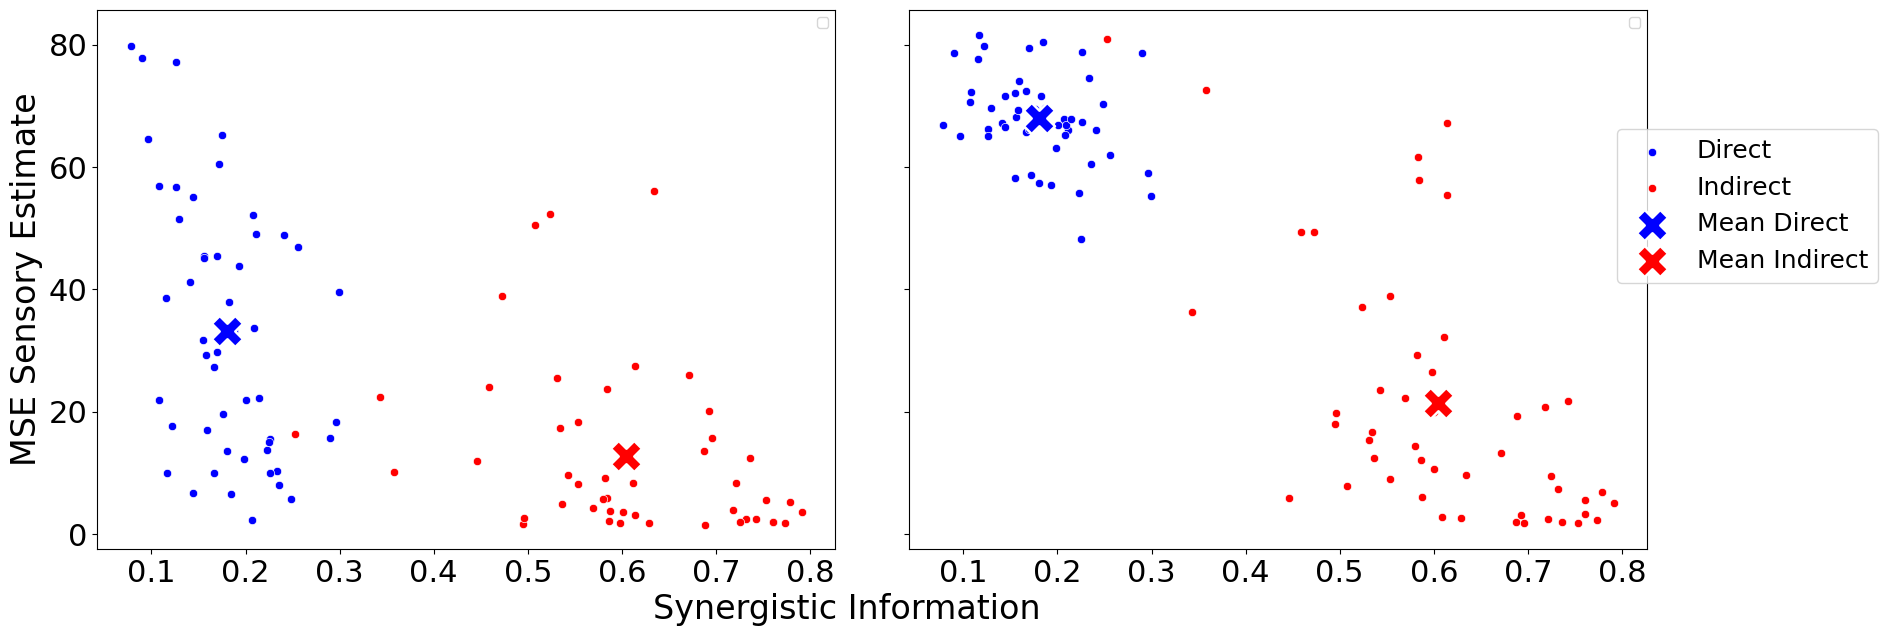


 SENT_sensory_myopic_2 | MSE_sensory_myopic_2
P-value SENT_sensory_myopic_2: 2.25e-06
P-value MSE_sensory_myopic_2: 9.96e-08


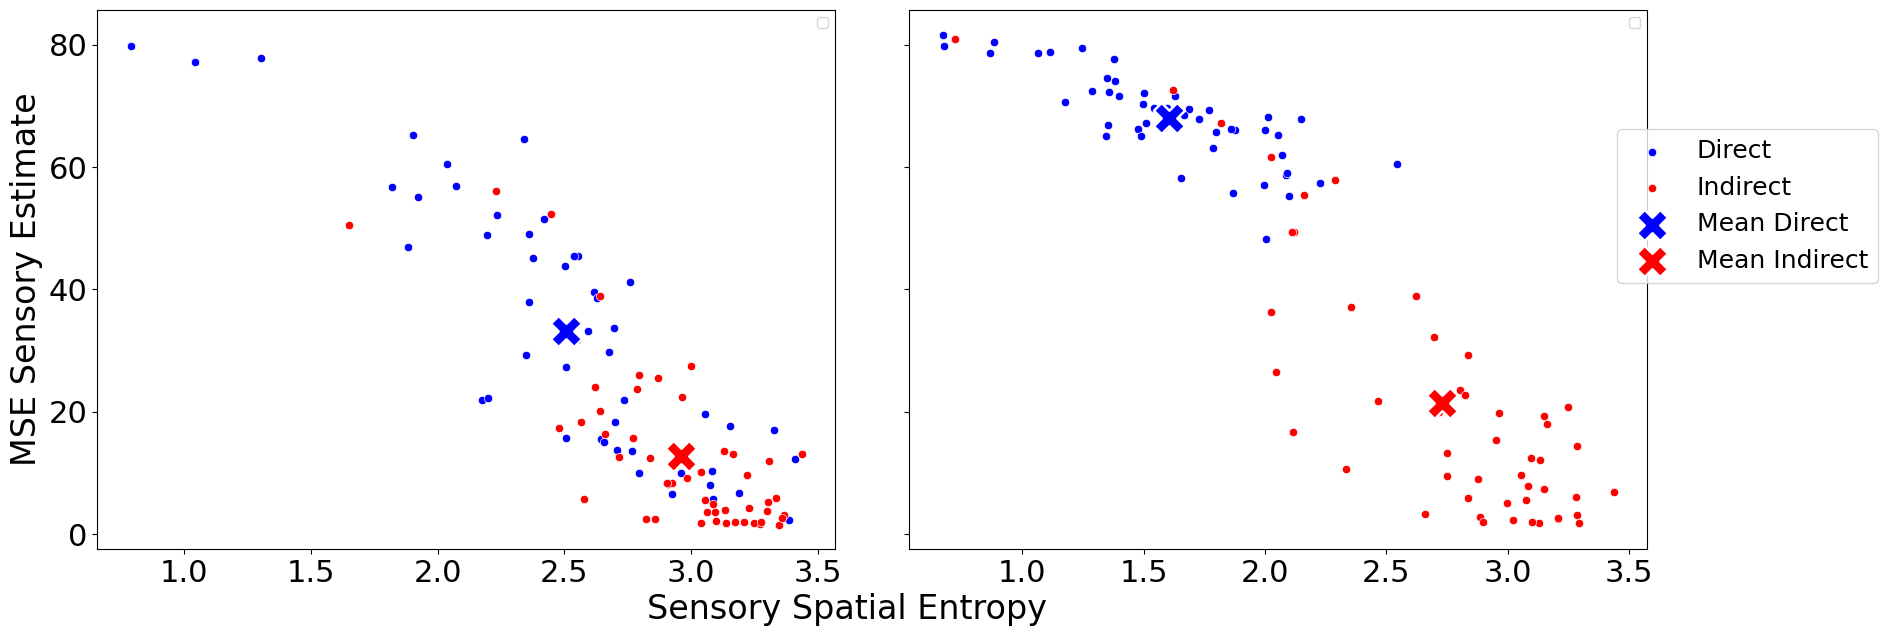


 MSE_sensory_myopic_2 | MSE_affordance_myopic
P-value MSE_sensory_myopic_2: 9.96e-08
P-value MSE_affordance_myopic: 6.91e-17


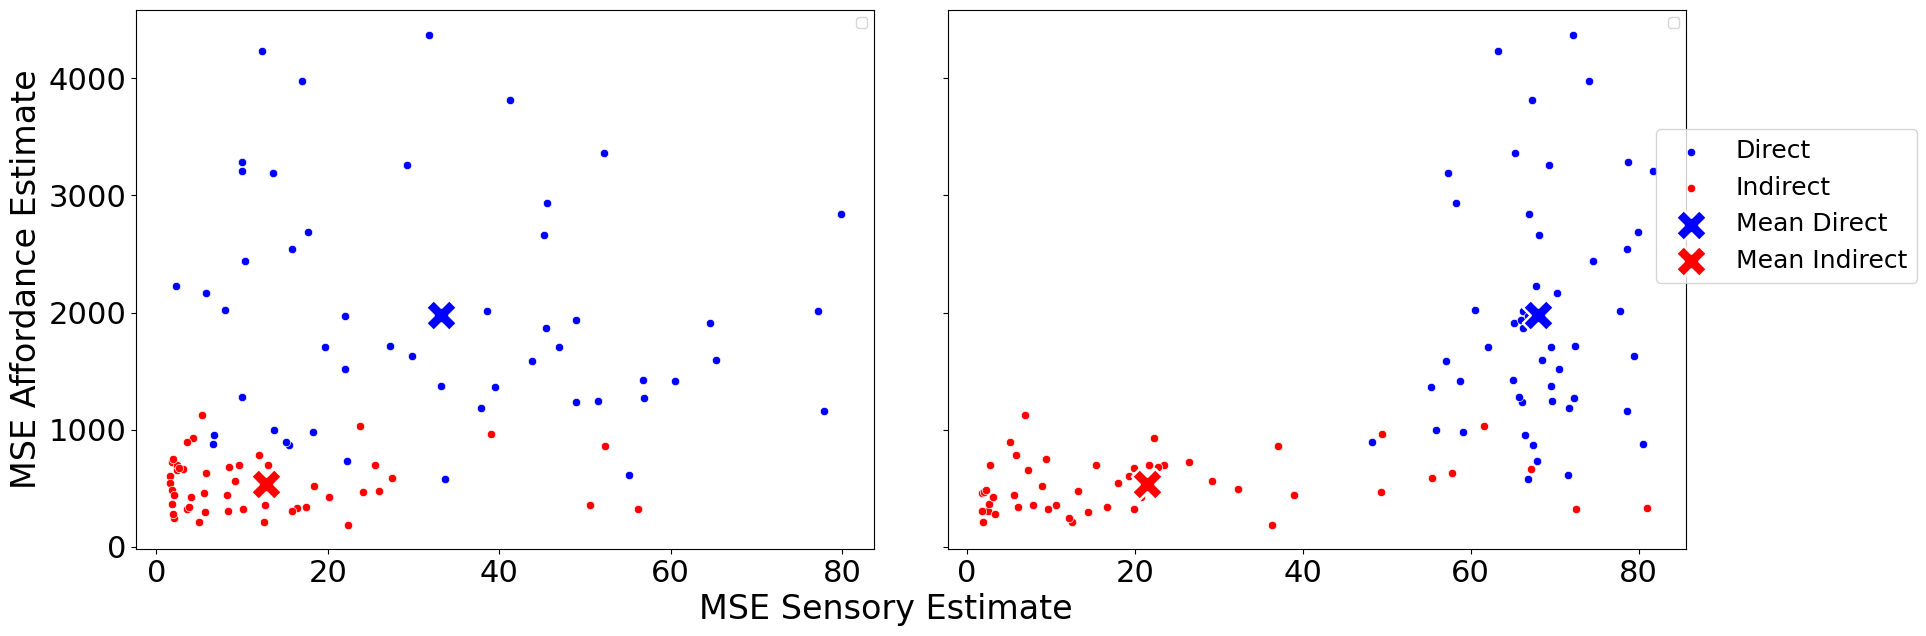


 Synergistic Information | MSE Affordance Estimate
P-value Synergistic Information: 1.06e-41
P-value MSE Affordance Estimate: 6.91e-17


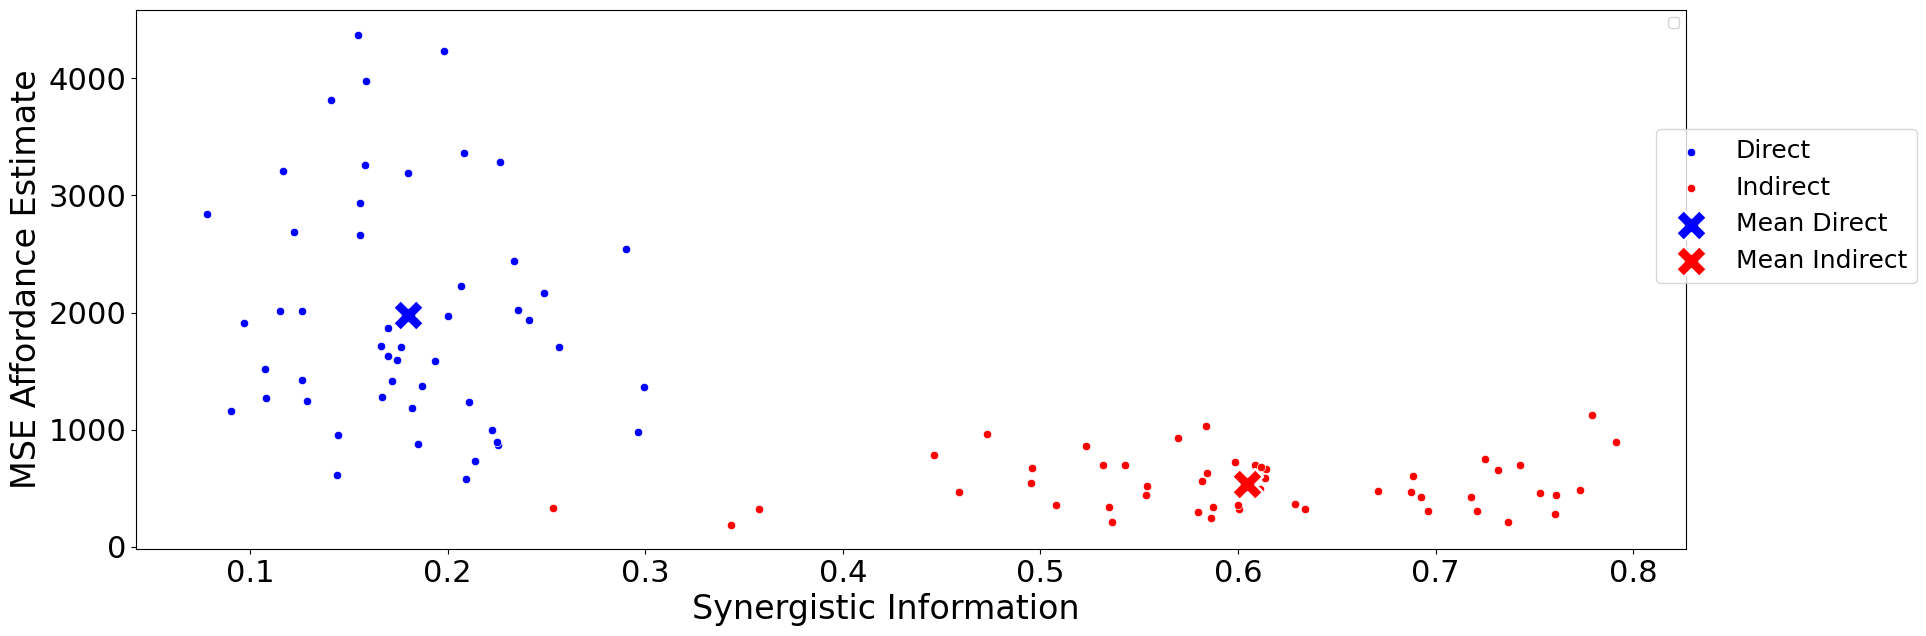

In [211]:
df = pd.read_csv("synergistic_encoders_cifar100_People")
print("Encoders 1")
#sns.set_theme()

plot_comparisons(df, signal=8, n=1)

In [203]:
df.groupby("Signal").agg(['mean', 'std'])

Unnamed: 0           MSE_sensory_myopic_1             \
             mean       std                 mean        std   
Signal                                                        
2            24.5  14.57738            54.459718  25.055220   
4            74.5  14.57738            42.421023  23.839343   
6           124.5  14.57738            37.240961  22.378029   
8           174.5  14.57738            33.175952  21.150702   

       MSE_sensory_myopic_2           MSE_sensory_synergy_1             \
                       mean       std                  mean        std   
Signal                                                                   
2                 81.625158  4.339478             50.625233  23.630607   
4                 76.919832  6.585567             30.739377  21.494333   
6                 70.167422  8.864158             17.114313  14.930339   
8                 67.963117  7.270984             12.791822  13.422438   

       MSE_sensory_synergy_2             ... SENT_sensory_synergy_2            \
                        mean        std  ...                   mean       std   
Signal                                   ...                                    
2                  68.250593  18.456258  ...               0.764787  0.449669   
4                  40.841003  23.669841  ...               1.759511  0.562984   
6                  29.928564  22.157991  ...               2.228867  0.526673   
8                  21.485000  20.706837  ...               2.727245  0.532691   

       MSE_affordance_myopic              MSE_affordance_synergy              \
                        mean          std                   mean         std   
Signal                                                                         
2                 2469.93740  1154.856295            1664.275413  754.472351   
4                 2234.10476  1075.862343             972.374368  450.836508   
6                 2102.93188  1013.560528             694.041495  306.581988   
8                 1977.14612   983.229775             533.449800  228.852962   

       SynInfo_affordance_myopic           SynInfo_affordance_synergy  \
                            mean       std                       mean   
Signal                                                                  
2                       0.011224  0.009390                   0.105449   
4                       0.054136  0.028908                   0.333249   
6                       0.109575  0.041145                   0.483357   
8                       0.180043  0.052850                   0.604487   

                  
             std  
Signal            
2       0.077835  
4       0.097028  
6       0.110214  
8       0.117652  

[4 rows x 34 columns]